In [16]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

from simtk import unit
from openmmtools.constants import kB
temperature = 300.0 * unit.kelvin
kT = kB * temperature

import mdtraj as md

import random
import os
from pymbar import EXP

hartree_to_kT = ((1*unit.hartree).in_units_of(unit.joules)*unit.AVOGADRO_CONSTANT_NA / kT)

Correction is 5.06 (0.43) kcal/mol for ligand 0


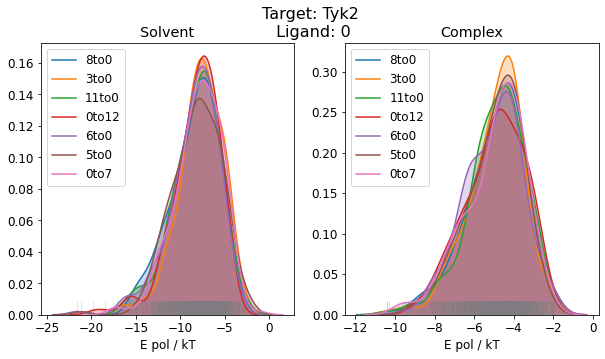

Correction is 3.21 (0.29) kcal/mol for ligand 1


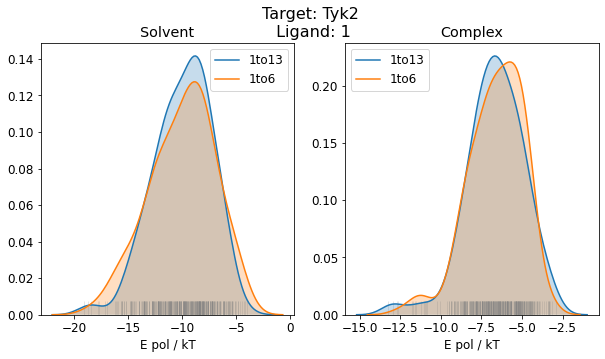

Correction is 4.68 (0.40) kcal/mol for ligand 2


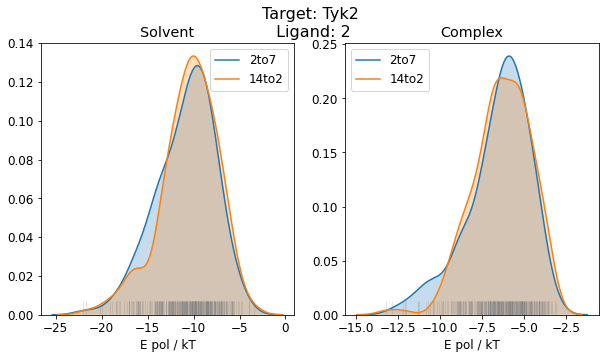

Correction is 4.90 (0.32) kcal/mol for ligand 3


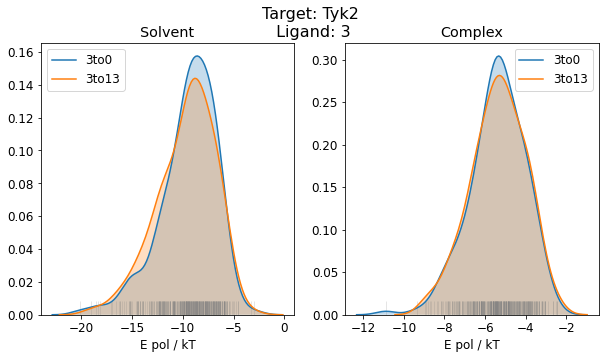

Correction is 4.33 (0.26) kcal/mol for ligand 4


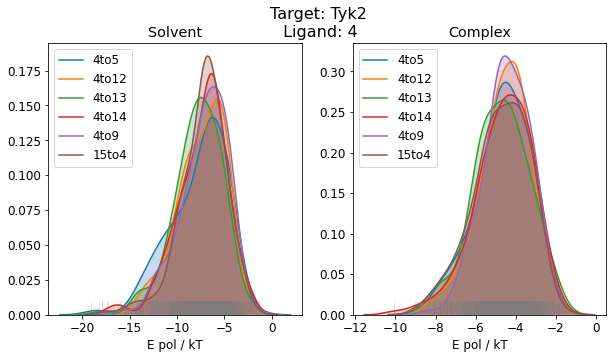

Correction is 4.97 (0.73) kcal/mol for ligand 5


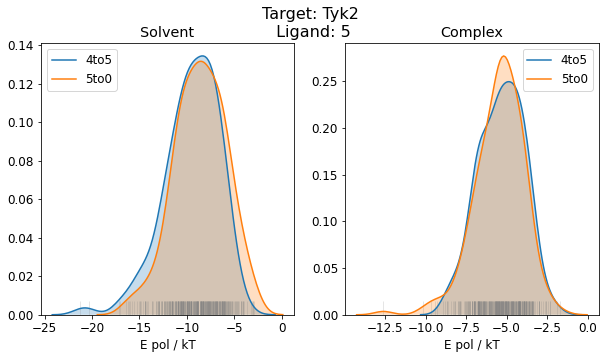

Correction is 4.65 (0.40) kcal/mol for ligand 6


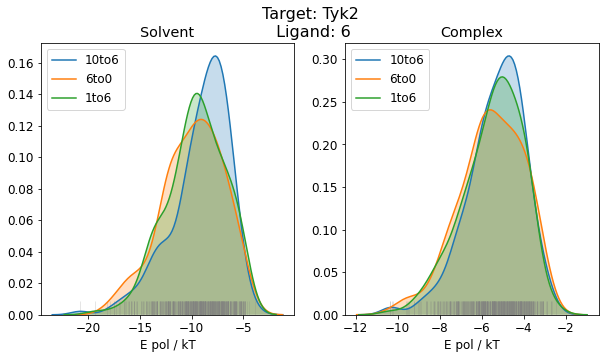

Correction is 4.76 (0.58) kcal/mol for ligand 7


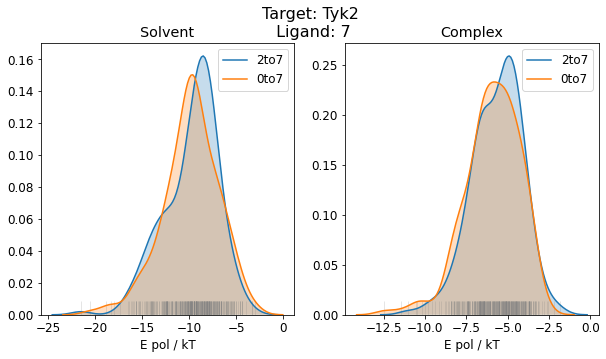

Correction is 4.67 (0.44) kcal/mol for ligand 8


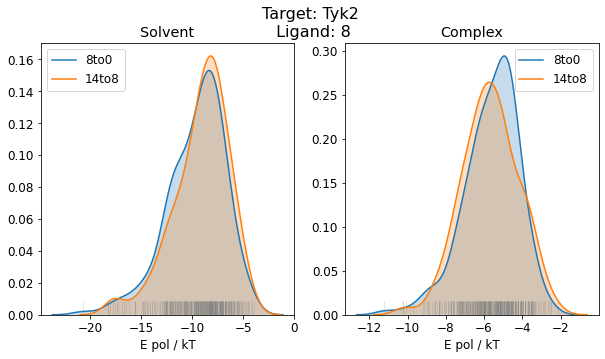

Correction is 4.80 (0.75) kcal/mol for ligand 9


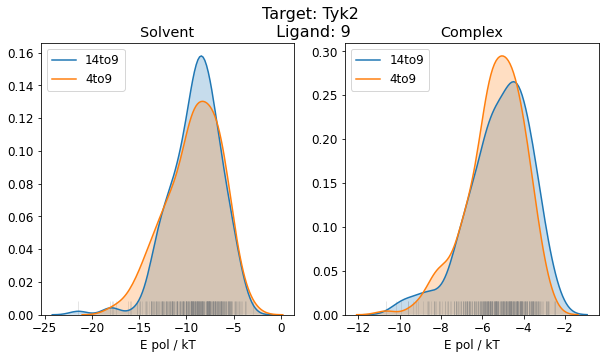

Correction is 5.24 (0.68) kcal/mol for ligand 10


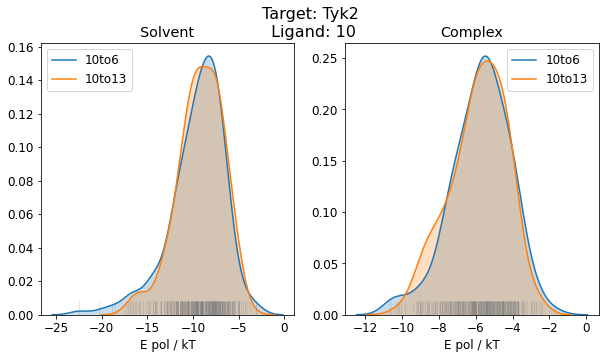

Correction is 3.94 (0.27) kcal/mol for ligand 11


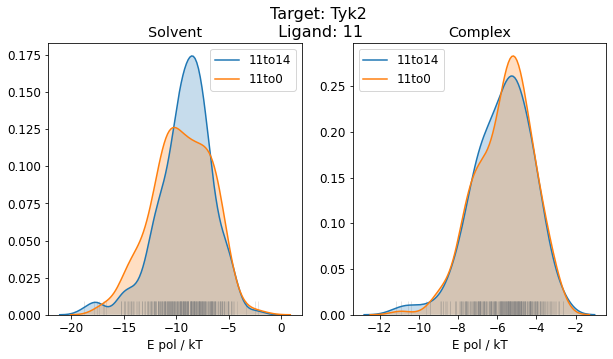

Correction is 3.54 (0.22) kcal/mol for ligand 12


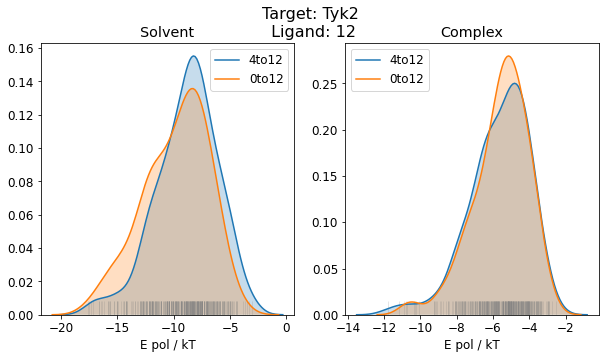

Correction is 5.77 (1.13) kcal/mol for ligand 13


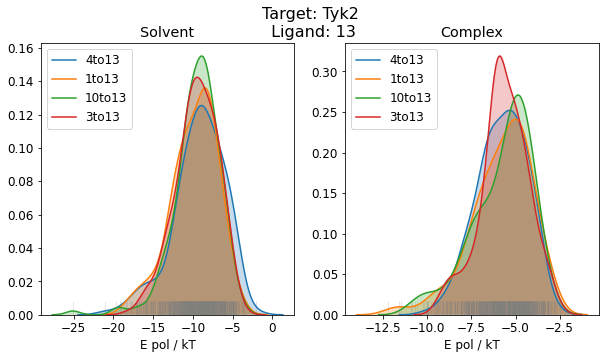

Correction is 4.58 (0.33) kcal/mol for ligand 14


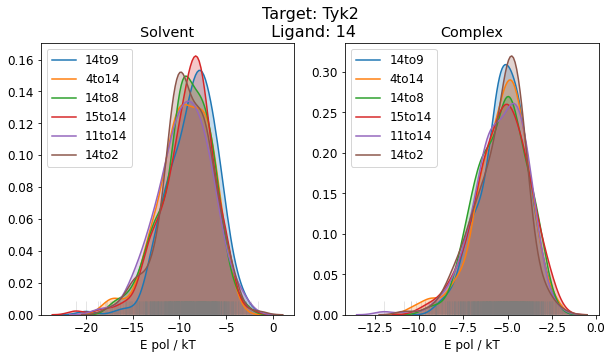

Correction is 4.02 (0.52) kcal/mol for ligand 15


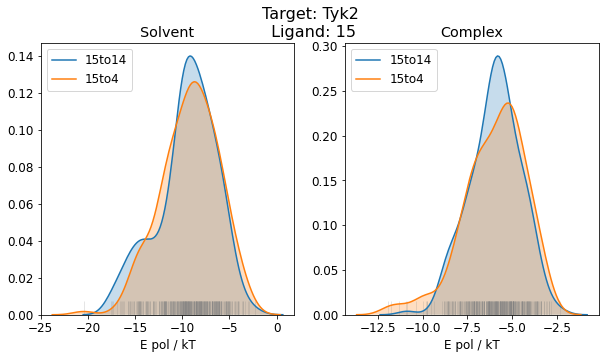

Correction is 4.35 (0.44) kcal/mol for ligand 0


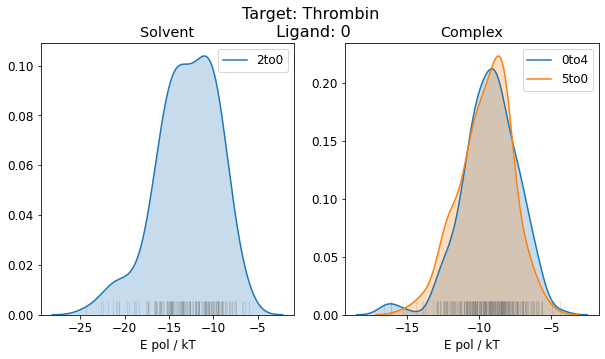

Correction is 5.67 (1.11) kcal/mol for ligand 3


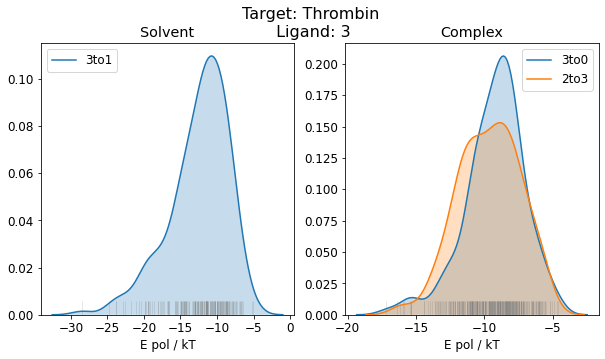

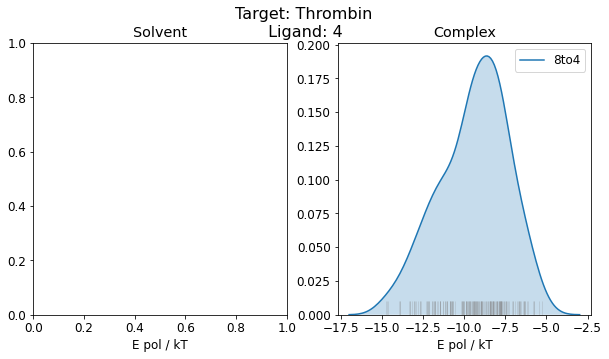

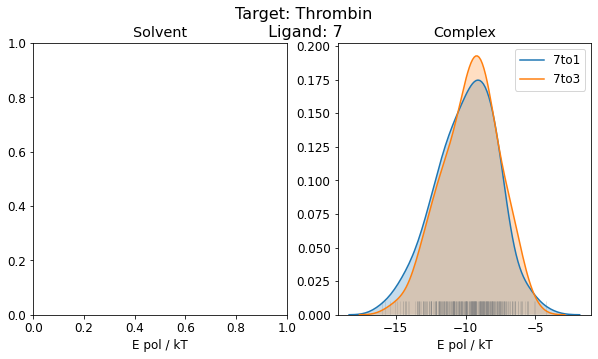

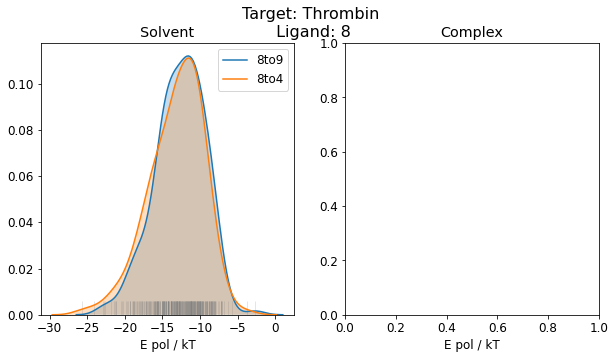

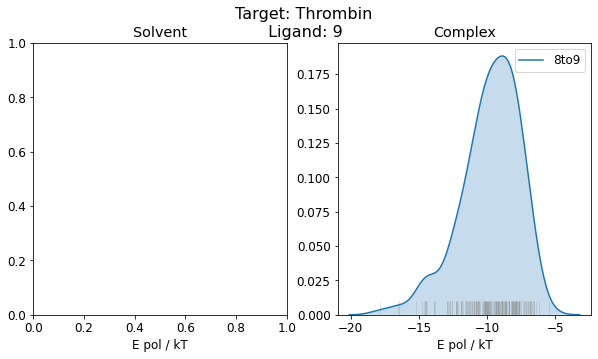

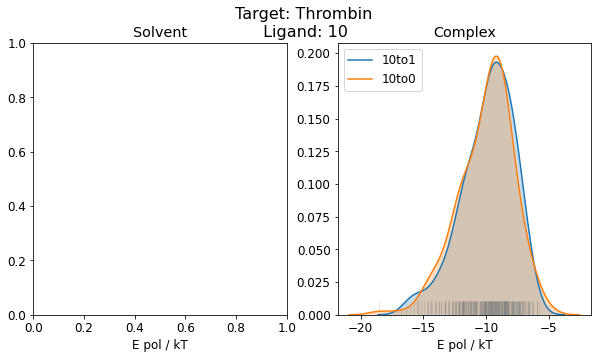

ValueError: invalid literal for int() with base 10: '1_protein.pdb'

In [48]:
systems = ['tyk2','thrombin','mcl1']

all_corrections = {x: {} for x in systems}
all_mm = {x: [] for x in systems}
new_results = {x: {} for x in systems}

folders = ['off100']

for target in systems:
    for folder in folders:
        outputs = {}
        ligands = []
        for d in os.listdir(f'../{target}/{folder}/'):
            if d[-3:] == '.pi':
                results = np.load(f'../{target}/{folder}/{d}',allow_pickle=True) 
                all_mm[target].append(results)
            else:
                pair = tuple([int(i) for i in d[3:].split('to')])
                outputs[pair] = d
                ligands.append(pair[0])
                ligands.append(pair[1])

        ligands = set(ligands)
        new_results[target] = {i:{} for i in ligands}
        oldnew = {0:'old',1:'new'}

        for ligand in ligands:
            for output in outputs.keys():
                if ligand in output:
                    endstate = oldnew[output.index(ligand)]
                    solventfile = f'../{target}/{folder}/{outputs[output]}/{endstate}_solvent.npy'
                    if os.path.exists(solventfile):
                        solvent = np.load(solventfile,allow_pickle=True).flatten()[0]
                        new_results[target][ligand][f'solvent-{outputs[output]}'] = solvent
                    complexfile = f'../{target}/{folder}/{outputs[output]}/{endstate}_complex.npy'
                    if os.path.exists(complexfile):
                        complex = np.load(complexfile,allow_pickle=True).flatten()[0]
                        new_results[target][ligand][f'complex-{outputs[output]}'] = complex           

        for ligand in new_results[target].keys():
            if len(new_results[target][ligand]) > 0:
                new_solvent_for_lig = []
                new_complex_for_lig = []
                fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
                for thing in new_results[target][ligand]:
                    if 'solvent' in thing:
                        Epol = new_results[target][ligand][thing]['Epol']*hartree_to_kT
                        if len(Epol) != 200:
                            print(ligand)
                            continue
                        sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[0])
                        sns.rugplot(Epol,ax=axes[0],alpha=0.2,color='grey')
                        new_solvent_for_lig.extend(Epol)
                    elif 'complex' in thing:
                        Epol = new_results[target][ligand][thing]['Epol']*hartree_to_kT
                        if len(Epol) != 200:
                            print(ligand)
                            continue
                        sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[1])
                        sns.rugplot(Epol,ax=axes[1],alpha=0.2,color='grey')
                        new_complex_for_lig.extend(Epol)


                if len(new_solvent_for_lig) > 0 and len(new_complex_for_lig) > 0:
                    bootstraps = []
                    for _ in range(100):
                        comp = random.choices(new_complex_for_lig, k=len(new_complex_for_lig))
                        sol = random.choices(new_solvent_for_lig, k=len(new_solvent_for_lig))
                        corr_comp, err_comp = EXP(np.asarray(comp))
                        corr_sol, err_sol = EXP(np.asarray(sol))
                        bootstraps.append((corr_comp - corr_sol)*0.593)
                    print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol for ligand {ligand}')
                    all_corrections[target][ligand] = (np.mean(bootstraps), np.std(bootstraps))
                axes[0].set_title('Solvent')
                axes[1].set_title('Complex')
                axes[0].set_xlabel('E pol / kT')
                axes[1].set_xlabel('E pol / kT')
                fig.suptitle(f"Target: {target.capitalize()}\n Ligand: {ligand}", fontsize=16)
                plt.show()

In [50]:
all_experimental = {'tyk2':[-9.540000 , -10.940000 , -8.980000 , -11.310000 , -9.210000 , -8.260000 , -10.980000 , -7.750000 , -9.560000 , -7.420000 , -11.280000 , -9 , -9.700000 , -11.700000 , -9.780000 , -10.530000],
                'thrombin':[-8.46 ,-8.25 ,-7.86 ,-7.48 ,-9.18 ,-8.22 ,-8.32 ,-7.58 ,-8.89 ,-8.91 ,-8.56],
                'mcl1':[-8.46 ,-8.25 ,-7.86 ,-7.48 ,-9.18 ,-8.22 ,-8.32 ,-7.58 ,-8.89 ,-8.91 ,-8.56]
}
import networkx as nx
from beryllium import plotting, stats

for target in systems:
    mm_g = nx.DiGraph()

    experimental = all_experimental[target]
    
    for sim in all_mm[target]:
        ligA = int(sim.directory[3:].split('to')[0])
        ligB = int(sim.directory[3:].split('to')[1])
        mm_g.add_edge(ligA, ligB,calc_DDG=-sim.bindingdg/sim.bindingdg.unit, calc_dDDG=sim.bindingddg/sim.bindingddg.unit,exp_DDG=(experimental[ligB] - experimental[ligA]),exp_dDDG=0.1)
        
        
    f_i_calc, C_calc = stats.mle(mm_g, factor='calc_DDG')
    variance = np.diagonal(C_calc)
    for i, (f_i, df_i) in enumerate(zip(f_i_calc, variance**0.5)):
        mm_g.nodes[i]['calc_DG'] = f_i
        mm_g.nodes[i]['calc_dDG'] = df_|i
        mm_g.nodes[i]['exp_DG'] = experimental[i]
        mm_g.nodes[i]['exp_dDG'] = 0.01

    plotting.plot_DGs(mm_g,title=f'{target} openff-1.0.0')

    
    import copy

    pol_g = copy.deepcopy(mm_g)

    for node in pol_g.nodes(data=True):
        try:
            node[1]['calc_DG'] =  node[1]['calc_DG'] - all_corrections[target][node[0]][0]
            node[1]['calc_dDG'] =  (node[1]['calc_dDG']**2 + all_corrections[target][node[0]][1]**2)**0.5 
        except:
            print(f'No correction for {target} ligand {node[0]}')
    plotting.plot_DGs(pol_g,title=f'{target} openff-1.0.0\n polarization correction')

NameError: name 'df_' is not defined

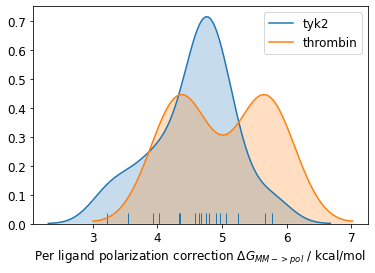

In [49]:
for target in systems:
    sns.kdeplot([i[0] for i in all_corrections[target].values()],label=target,shade=True)
    sns.rugplot([i[0] for i in all_corrections[target].values()])

plt.xlabel('Per ligand polarization correction $\Delta G_{MM->pol}$ / kcal/mol')
plt.legend()
plt.show()

No handles with labels found to put in legend.


<mdtraj.Topology with 3 chains, 624 residues, 1893 atoms, 1271 bonds>
<mdtraj.Trajectory with 201 frames, 1893 atoms, 624 residues, and unitcells>


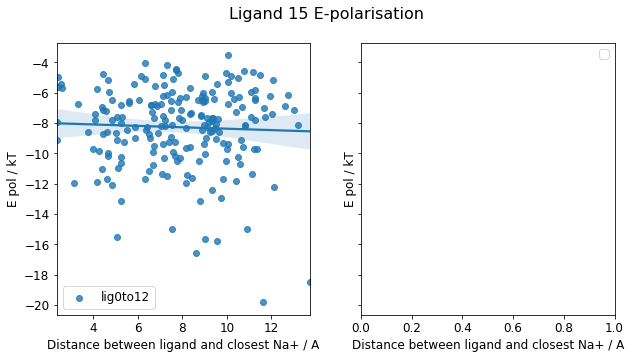

In [47]:
ax = {'solvent':0, 'complex':1}


fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5),sharey=True)
phase = 'solvent'
directory = 'lig0to12'

# if str(ligand) == thing.split('to')[1]:
#     state = 'new'
# else:
#     state = 'old'

state = 'old'

topology = md.load(f'../tyk2/off100/{directory}/{state}_{phase}.pdb').topology
t = md.load(f'../tyk2/off100/{directory}/{state}_{phase}_aligned.dcd', top=topology)

print(topology)
print(t)
ligand_ids = []
ions_ids = []
for r in topology.residues:
    if r.name == 'MOL': 
        for a in r.atoms:
            ligand_ids.append(a.index)
    if r.name == 'NA': 
          for a in r.atoms:
            ions_ids.append(a.index)

comparisons = [[i,j] for i in ligand_ids for j in ions_ids]
ion_dist = md.compute_distances(t,comparisons)


closest_ion = np.min(ion_dist,axis=1)

sns.regplot(10*closest_ion[1:],new_results[target][0][f'{phase}-{directory}']['Epol']*hartree_to_kT,ax=axes[ax[phase]],label=directory)


axes[0].set_xlabel('Distance between ligand and closest Na+ / A')
axes[0].set_ylabel('E pol / kT')
axes[0].legend()
axes[1].set_xlabel('Distance between ligand and closest Na+ / A')
axes[1].set_ylabel('E pol / kT')
axes[1].legend()
fig.suptitle(f"Ligand {ligand} E-polarisation", fontsize=16)
plt.show()

In [44]:
print(new_results[target][0])

{'solvent-lig8to0': {'QMMM': array([-1748.13538612, -1748.06242201, -1748.06611038, -1748.0748796 ,
       -1748.07687373, -1748.06840692, -1748.09252716, -1748.09654663,
       -1748.09113189, -1748.08662819, -1748.04254393, -1748.06400759,
       -1748.07810157, -1748.07985218, -1748.06842031, -1748.08204953,
       -1748.07143799, -1748.0689702 , -1748.09583412, -1748.08471665,
       -1748.08636144, -1748.09808182, -1748.06594133, -1748.07756321,
       -1748.08911321, -1748.08312938, -1748.05237619, -1748.08639884,
       -1748.05632598, -1748.07688015, -1748.04470972, -1748.04842031,
       -1748.08691609, -1748.07484732, -1748.07897236, -1748.05255611,
       -1748.06199179, -1748.09388972, -1748.09357136, -1748.06392076,
       -1748.07288636, -1748.09914497, -1748.050499  , -1748.09601689,
       -1748.06309212, -1748.07601024, -1748.09262988, -1748.04312231,
       -1748.06850694, -1748.10272081, -1748.07487819, -1748.07337569,
       -1748.0868    , -1748.08544393, -1748.093